In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pytensor as pt
import pybaseball 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_SEED = 504

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.19.1


In [2]:
from retrieve_sql_module import get_table

fangraphs_batting_stats_2024 = get_table("fangraphs_batting_stats_2024")

In [3]:
fitting_subset = (
    fangraphs_batting_stats_2024
    .assign(
        label=lambda df: df["Name"].astype(str) + " - " + 
                         df["Season"].astype(str) + " - " + 
                         df["Team"].astype(str)
    )
)

In [4]:
fitting_subset

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,Events,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,key_mlbam,pos,label
0,6184,2024,J.D. Martinez,NYM,36,120,434,495,102,61,...,299,0.148,0.293,0.261,0.484,0.356,0.8,502110.0,DH,J.D. Martinez - 2024 - NYM
1,10324,2024,Marcell Ozuna,ATL,33,162,606,688,183,113,...,441,0.138,0.273,0.290,0.584,0.405,5.0,542303.0,DH,Marcell Ozuna - 2024 - ATL
2,19755,2024,Shohei Ohtani,LAD,29,159,636,731,197,98,...,482,0.144,0.269,0.320,0.678,0.448,9.0,660271.0,DH,Shohei Ohtani - 2024 - LAD
3,31837,2024,Masataka Yoshida,BOS,30,108,378,421,106,75,...,328,0.186,0.246,0.260,0.401,0.324,0.9,807799.0,DH,Masataka Yoshida - 2024 - BOS
4,14894,2024,Tony Kemp,BAL,32,5,9,10,0,0,...,8,0.105,0.184,0.142,0.192,0.198,-0.1,643393.0,2B,Tony Kemp - 2024 - BAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,19287,2024,Adolis Garcia,TEX,31,154,580,637,130,78,...,409,0.127,0.294,0.229,0.422,0.308,0.1,666969.0,RF,Adolis Garcia - 2024 - TEX
636,26197,2024,Andrew Vaughn,CHW,26,149,570,619,140,90,...,443,0.168,0.267,0.245,0.449,0.321,-0.1,683734.0,1B,Andrew Vaughn - 2024 - CHW
637,19251,2024,Pete Alonso,NYM,29,162,608,695,146,81,...,440,0.192,0.289,0.246,0.470,0.345,2.6,624413.0,1B,Pete Alonso - 2024 - NYM
638,17982,2024,Ty France,- - -,29,140,479,535,112,75,...,370,0.128,0.237,0.229,0.394,0.305,-0.8,664034.0,1B,Ty France - 2024 - - - -


In [5]:
fitting_subset['hr_rate'] = fitting_subset['HR'] / fitting_subset['PA']

In [6]:
fitting_subset.sort_values(by="hr_rate", ascending = False).head(5)

,IDfg,Season,Name,Team,Age,G,AB,PA,H,1B,...,CStr%,CSW%,xBA,xSLG,xwOBA,L-WAR,key_mlbam,pos,label,hr_rate
402,25448,2024,Greg Jones,COL,26,6,5,6,1,0,...,0.103,0.310,0.199,0.791,0.448,0.1,NaN,RF,Greg Jones - 2024 - COL,0.166667
161,19273,2024,Stone Garrett,WSN,28,2,5,6,3,1,...,0.032,0.129,0.602,1.390,0.799,0.3,656448.0,DH,Stone Garrett - 2024 - WSN,0.166667
7,25705,2024,Dustin Harris,TEX,24,2,6,7,2,0,...,0.174,0.304,0.285,0.512,0.385,0.2,NaN,DH,Dustin Harris - 2024 - TEX,0.142857
322,19928,2024,Ryan McKenna,- - -,27,13,14,15,3,1,...,0.115,0.212,0.169,0.383,0.260,-0.1,663630.0,LF,Ryan McKenna - 2024 - - - -,0.133333
409,27493,2024,Rece Hinds,CIN,23,24,46,51,12,2,...,0.114,0.310,0.254,0.625,0.396,0.6,NaN,CF,Rece Hinds - 2024 - CIN,0.098039


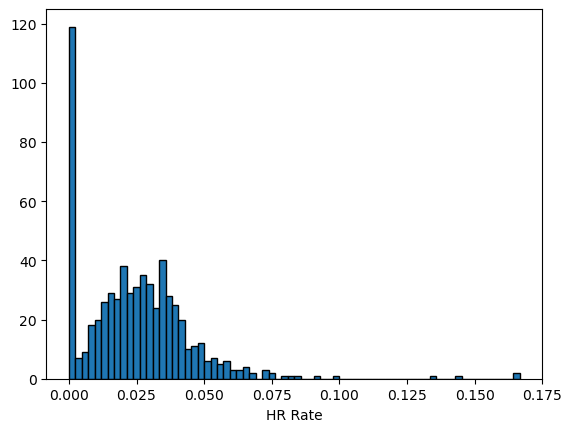

In [7]:
plt.hist(fitting_subset['hr_rate'].dropna(), bins = 70, edgecolor='black')
plt.xlabel("HR Rate")
plt.show()

In [8]:
pa, hr = fitting_subset[["PA", "HR"]].astype(np.int32).to_numpy().T
coords = {"batter":fitting_subset[['label']].to_numpy().squeeze()}

In [9]:
coords

{'batter': array(['J.D. Martinez - 2024 - NYM', 'Marcell Ozuna - 2024 - ATL',
        'Shohei Ohtani - 2024 - LAD', 'Masataka Yoshida - 2024 - BOS',
        'Tony Kemp - 2024 - BAL', 'Matt Mervis - 2024 - CHC',
        'Giancarlo Stanton - 2024 - NYY', 'Dustin Harris - 2024 - TEX',
        'Ryan Bliss - 2024 - SEA', 'Michael Helman - 2024 - MIN',
        'Daniel Vogelbach - 2024 - TOR', 'Samad Taylor - 2024 - SEA',
        'Levi Jordan - 2024 - CIN', 'Casey Schmitt - 2024 - SFG',
        'Carlos Narvaez - 2024 - NYY', 'Matt Duffy - 2024 - TEX',
        'Cooper Hummel - 2024 - HOU', 'Duke Ellis - 2024 - - - -',
        'Jair Camargo - 2024 - MIN', 'Sandro Fabian - 2024 - TEX',
        'Joc Pederson - 2024 - ARI', 'Tyler Heineman - 2024 - - - -',
        'Davis Wendzel - 2024 - TEX', 'Bryce Teodosio - 2024 - LAA',
        'Conner Capel - 2024 - CIN', 'Luken Baker - 2024 - STL',
        'Joey Wiemer - 2024 - - - -', 'Patrick Bailey - 2024 - SFG',
        'Cal Raleigh - 2024 - SEA', 'Jake 

Uninformative model with p modeled as a uniform probability
$$
p_i \sim \text{Uniform}(0,1)
$$

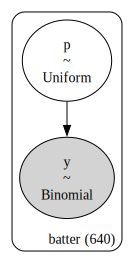

In [13]:
with pm.Model(coords=coords) as uninformative_prior_model:

    p = pm.Uniform("p", 0, 1, dims = "batter")

    y = pm.Binomial("y", n = pa, p = p, observed = hr, dims="batter")
pm.model_to_graphviz(uninformative_prior_model)

In [14]:
with uninformative_prior_model:
    uninformed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


In [15]:
uninformed_prior_trace

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

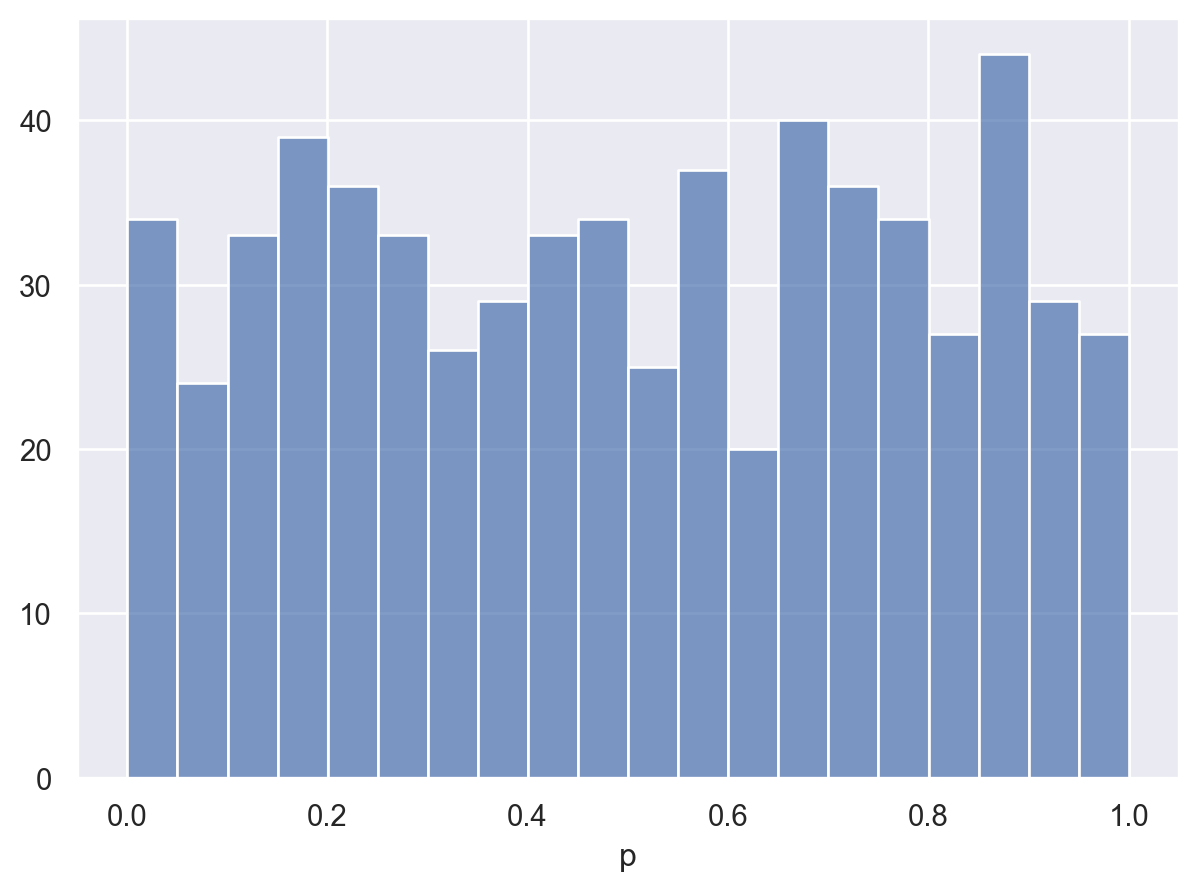

In [16]:
so.Plot(uninformed_prior_trace.prior['p'].sel(chain=[0], draw = [0]).squeeze()).add(so.Bars(), so.Hist(bins = 20))

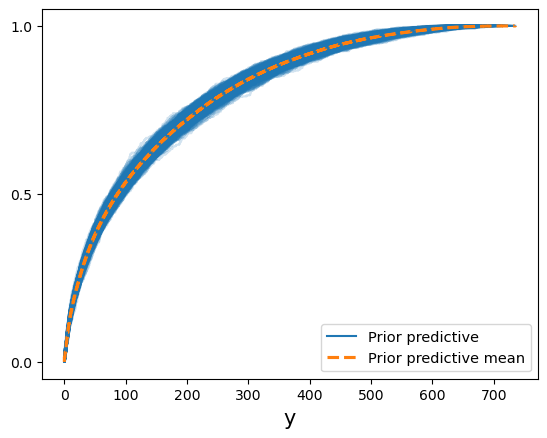

In [17]:
az.plot_ppc(uninformed_prior_trace, group = 'prior', kind = 'cumulative');

In [18]:
with uninformative_prior_model:
    trace = pm.sample(draws=100,tune = 100,cores =4, chains = 4, random_seed = RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [19]:
with uninformative_prior_model:
    trace = pm.sample(draws = 1000, tune = 1000, cores = 4, chains = 4, random_seed = RANDOM_SEED)
uninformed_prior_trace.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [20]:
az.summary(trace).sort_values("r_hat", ascending=False).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[Masataka Yoshida - 2024 - BOS],0.026,0.008,0.012,0.040,0.0,0.0,5535.0,2650.0,1.01
p[Spencer Steer - 2024 - CIN],0.032,0.007,0.020,0.045,0.0,0.0,7667.0,2218.0,1.01
p[Zach Neto - 2024 - LAA],0.040,0.008,0.026,0.055,0.0,0.0,7873.0,2680.0,1.01
p[Jonathan Aranda - 2024 - TBR],0.048,0.017,0.018,0.080,0.0,0.0,6111.0,2424.0,1.00
p[Hunter Goodman - 2024 - COL],0.062,0.015,0.035,0.091,0.0,0.0,5778.0,2414.0,1.00


<Axes: title={'center': 'p\nMookie Betts - 2024 - LAD'}, xlabel='Total number of draws', ylabel='ESS'>

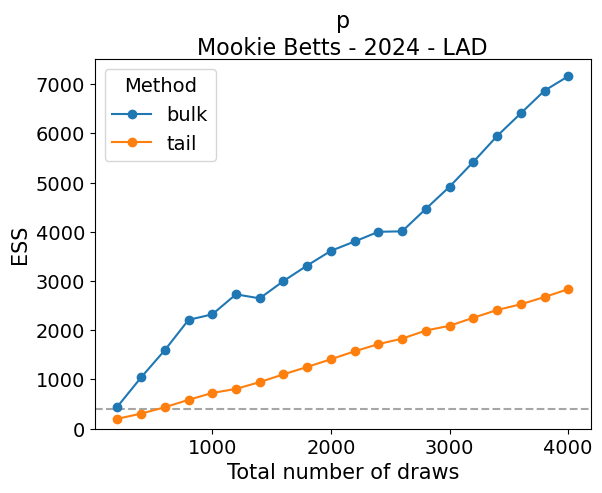

In [21]:
az.plot_ess(uninformed_prior_trace, var_names=["p"], coords ={"batter":["Mookie Betts - 2024 - LAD"]}, kind = "evolution")

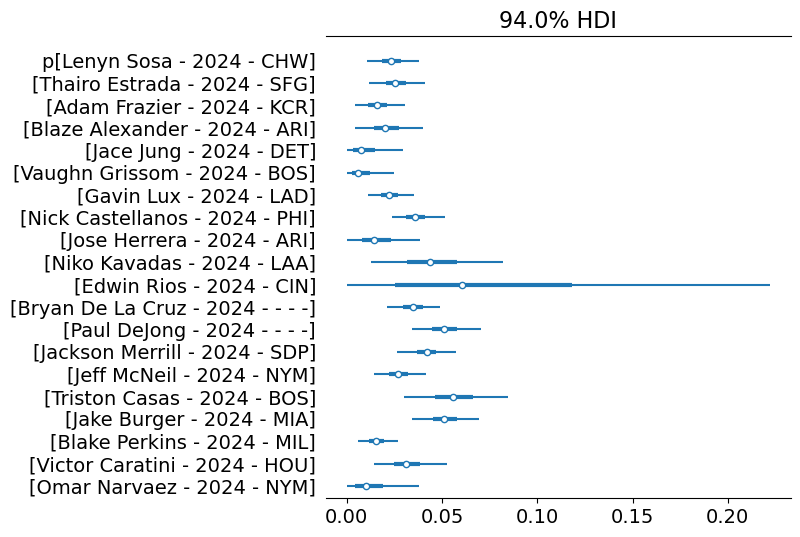

In [22]:
sampled_batters = fitting_subset.sample(n=20, random_state = 25555)

selected_data = sampled_batters[['label','hr_rate']]

SAMPLE_BATTERS,obs_rates = selected_data.to_numpy().T

(ax,) = az.plot_forest(uninformed_prior_trace, coords = {"batter":list(SAMPLE_BATTERS)}, combined = True)

In [23]:
uninformed_means = uninformed_prior_trace.posterior.mean(dim=("chain","draw"))
uninformed_hdi = az.hdi(uninformed_prior_trace)

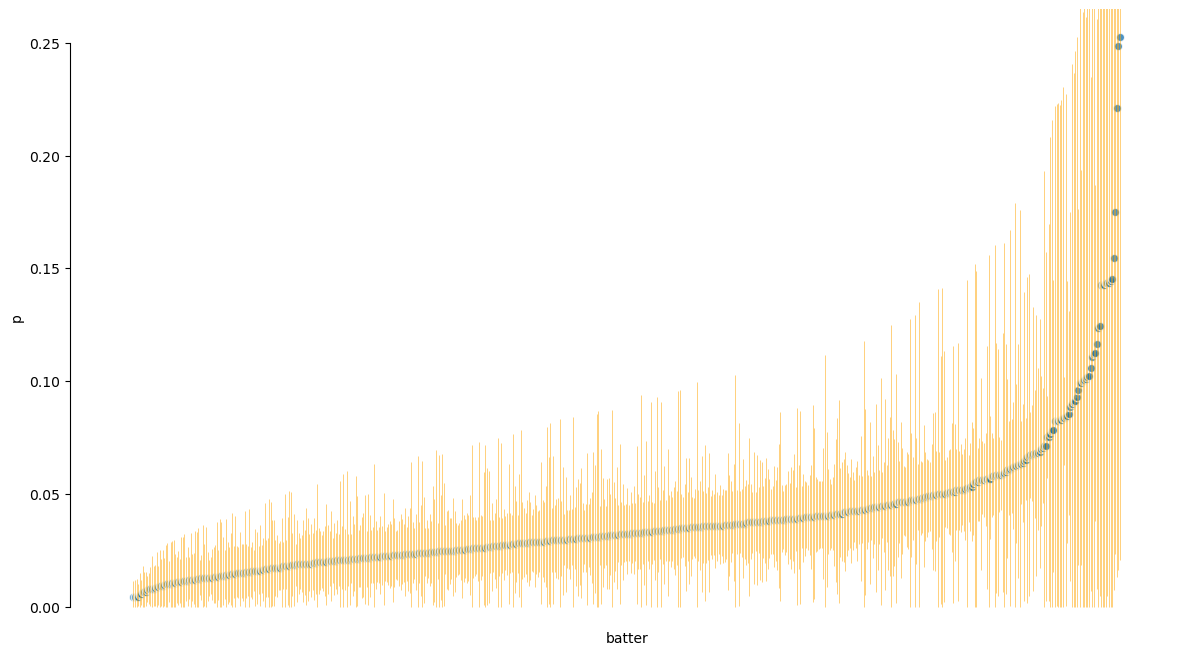

In [24]:
fig, ax = plt.subplots(figsize=(14,8))

uninformed_means_iter = uninformed_means.sortby("p")
uninformed_hdi_iter = uninformed_hdi.sortby(uninformed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    uninformed_hdi_iter.p.sel(hdi="lower"),
    uninformed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
    linewidth=0.6
)
uninformed_means_iter.plot.scatter(x="batter", y = "p", ax=ax, alpha = 0.8)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10,trim=True,bottom=True)

Text(0, 0.5, 'Uncertainty of estimate')

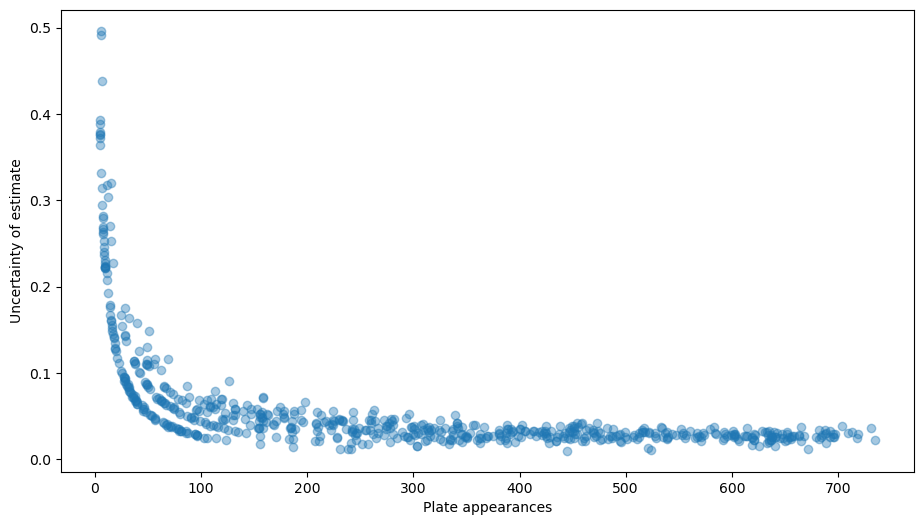

In [25]:
uncertainty = uninformed_hdi.p.sel(hdi="higher") - uninformed_hdi.p.sel(hdi = "lower")

plt.figure(figsize=(11,6))
plt.plot(pa, uncertainty, "o", alpha = 0.4)
plt.xlabel("Plate appearances")
plt.ylabel("Uncertainty of estimate")

Text(0.5, 0, 'Home Run Rate')

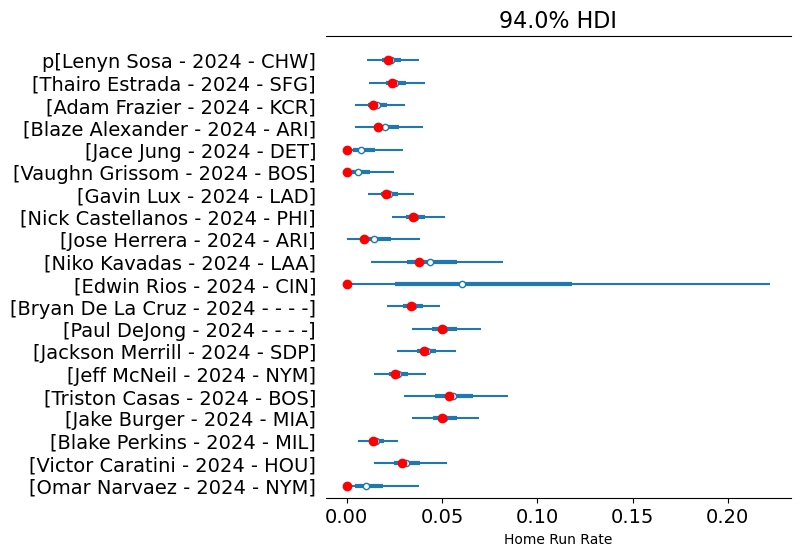

In [26]:
(ax,) = az.plot_forest(uninformed_prior_trace, coords = {"batter":SAMPLE_BATTERS}, combined = True)
ax.plot(obs_rates[::-1], ax.get_yticks(), "ro")
ax.set_xlabel("Home Run Rate")

In [27]:
with uninformative_prior_model:
    pm.sample_posterior_predictive(uninformed_prior_trace, extend_inferencedata=True)

Sampling: [y]


array([<Axes: xlabel='y'>], dtype=object)

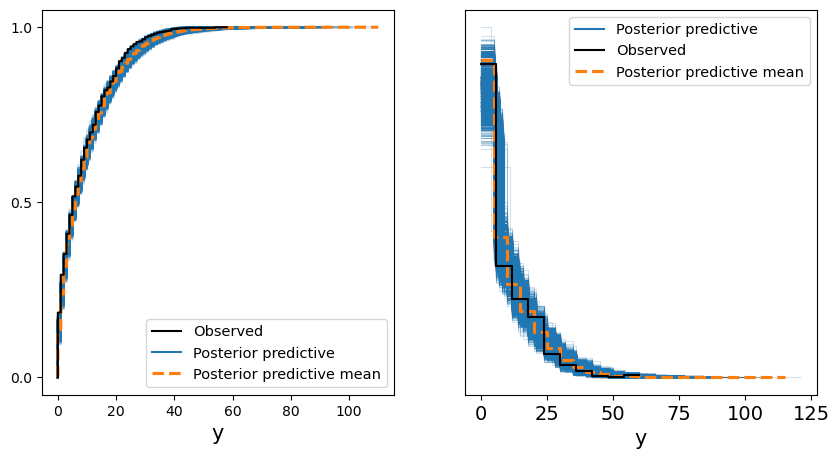

In [28]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
az.plot_ppc(uninformed_prior_trace, group = "posterior", kind = "cumulative", ax=axes[0])
az.plot_ppc(uninformed_prior_trace, group = "posterior", ax = axes[1])

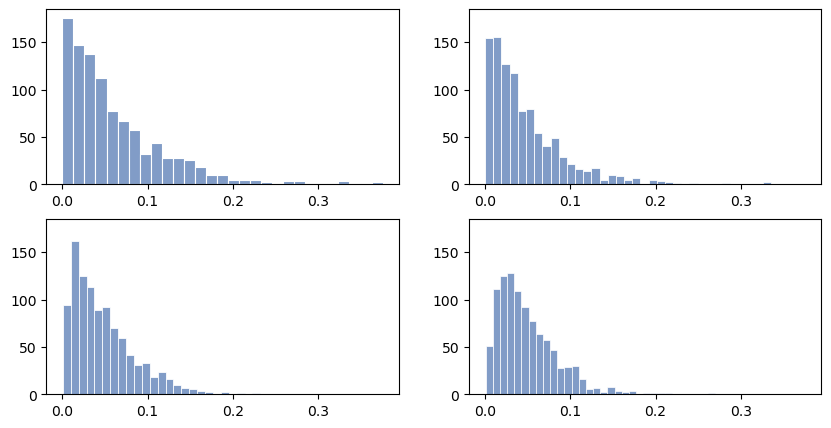

In [29]:
fig,axes = plt.subplots(2,2, figsize=(10,5), sharex=True, sharey=True)

for params, ax in zip([(1,15), (1,20), (1.5,30), (2,40)], axes.flat):
    so.Plot(pm.Beta.dist(*params, shape=1000).eval()).add(so.Bars(), so.Hist()).on(ax).plot()

In [30]:
pm.find_constrained_prior(
    pm.Beta,
    lower=0.01,
    upper=0.11,
    init_guess={"alpha" : 2, "beta" : 40}
)

/var/folders/s2/nj72w9kx55v5zn8_gfnr84qr0000gn/T/ipykernel_11400/1056268626.py:1: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  pm.find_constrained_prior(


{'alpha': 3.1375906600926915, 'beta': 60.555650325086305}

/var/folders/s2/nj72w9kx55v5zn8_gfnr84qr0000gn/T/ipykernel_11400/214001403.py:2: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  beta_params = pm.find_constrained_prior(


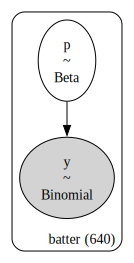

In [31]:
with pm.Model(coords=coords) as informative_prior_model:
    beta_params = pm.find_constrained_prior(
        pm.Beta,
        lower=0.05,
        upper=0.09,
        init_guess={"alpha": 2, "beta" : 40},
    )

    p = pm.Beta("p", **beta_params, dims="batter")

    y = pm.Binomial("y", n = pa, p = p, observed=hr, dims = "batter")

pm.model_to_graphviz(informative_prior_model)

In [32]:
with informative_prior_model:
    informed_prior_trace = pm.sample_prior_predictive(1000)

Sampling: [p, y]


<Axes: xlabel='y'>

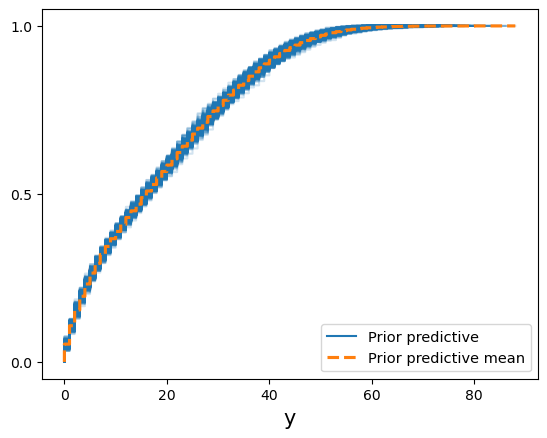

In [33]:
az.plot_ppc(informed_prior_trace, group = "prior", kind = "cumulative")

In [34]:
with informative_prior_model:
    informed_prior_trace.extend(pm.sample(cores=4, chains=4, random_seed = RANDOM_SEED))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [35]:
informed_means = informed_prior_trace.posterior.mean(dim=("chain","draw"))
informed_hdi = az.hdi(informed_prior_trace)

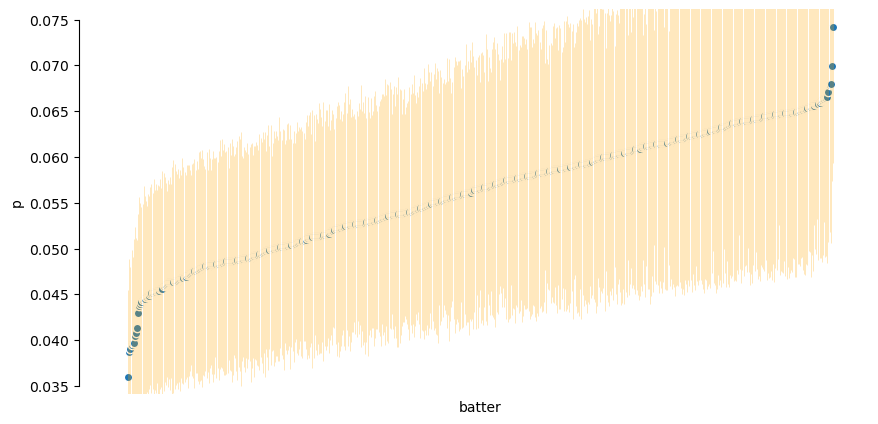

In [36]:
fig, ax = plt.subplots(figsize=(10,5))

informed_means_iter = informed_means.sortby("p")
informed_hdi_iter = informed_hdi.sortby(informed_means_iter.p)
ax.vlines(
    np.arange(fitting_subset.shape[0]),
    informed_hdi_iter.p.sel(hdi="lower"),
    informed_hdi_iter.p.sel(hdi="higher"),
    color="orange",
    alpha=0.3,
    linewidth=0.6
)
informed_means_iter.plot.scatter(x="batter", y = "p", ax=ax)

ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(offset=10, trim=True, bottom=True)

Partial pooling model

/var/folders/s2/nj72w9kx55v5zn8_gfnr84qr0000gn/T/ipykernel_11400/251870041.py:7: RuntimeWarning: divide by zero encountered in divide
  partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1 / var_rates + 1 /pop_var)
/var/folders/s2/nj72w9kx55v5zn8_gfnr84qr0000gn/T/ipykernel_11400/251870041.py:7: RuntimeWarning: invalid value encountered in multiply
  partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1 / var_rates + 1 /pop_var)


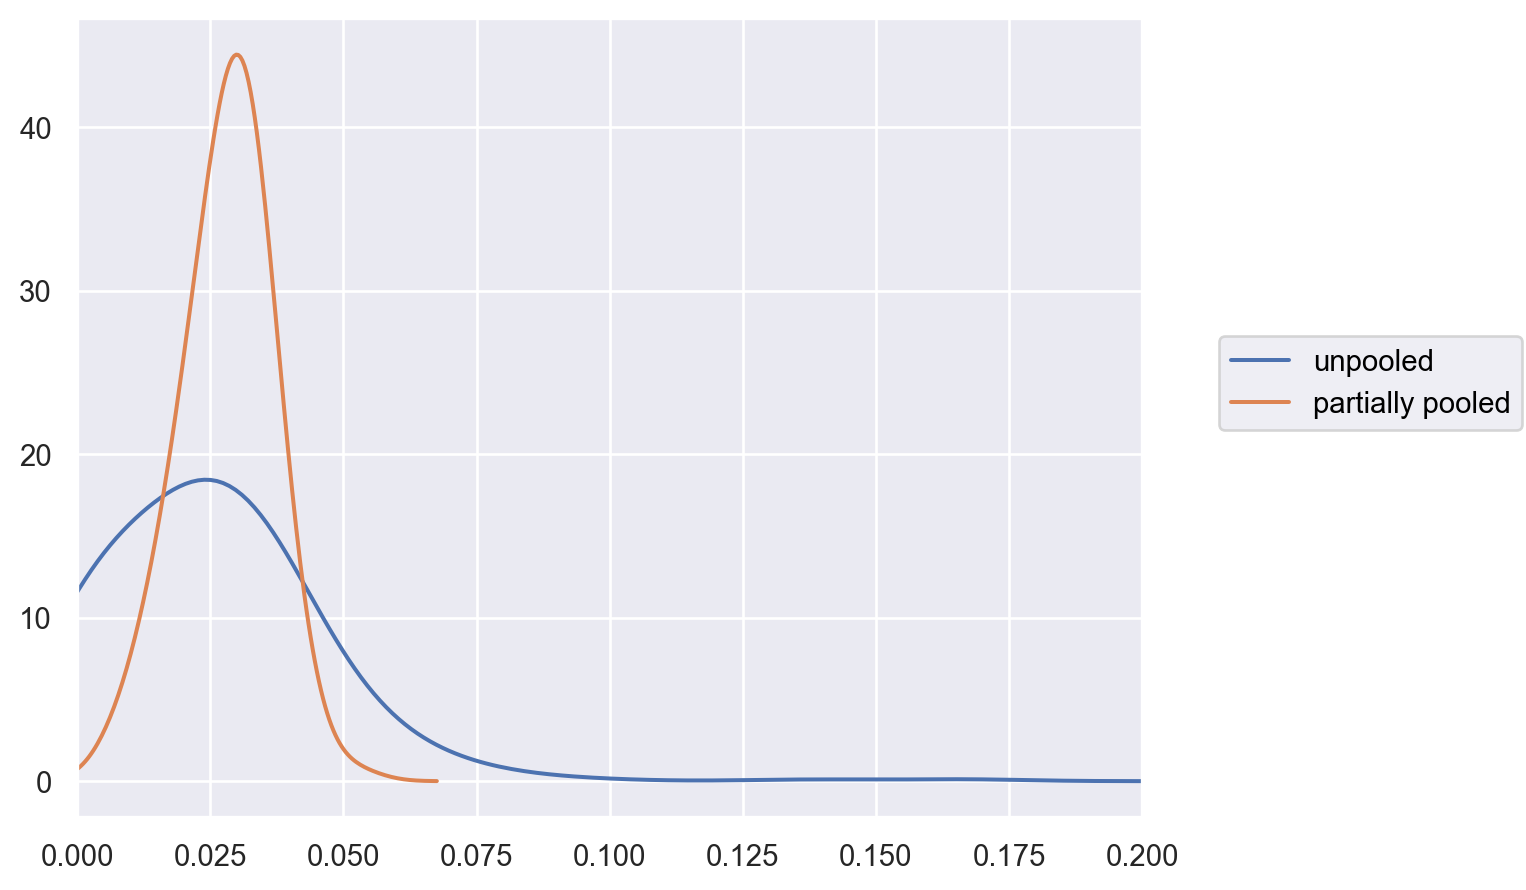

In [37]:
rates = hr / pa
var_rates = rates * (1 - rates)

pop_rate = (fitting_subset["HR"].sum() / fitting_subset["PA"].sum())
pop_var = pop_rate * (1 - pop_rate)

partial_pooled_rates = (rates * (1/var_rates) + pop_rate * (1/pop_var)) / (1 / var_rates + 1 /pop_var)

(
    so.Plot()
    .add(so.Line(color="C0"), so.KDE(bw_adjust=2), x=rates, label = "unpooled")
    .add(so.Line(color="C1"), so.KDE(bw_adjust=2), x=partial_pooled_rates, label="partially pooled")
    .limit(x=(0,0.2))
)

$$
p_i \sim Beta(\alpha, \beta)
$$

In [38]:
def factorize(dataset, col_name):
    dataset["idx"] = dataset[col_name].astype("category").cat.codes
    categories = dataset[[col_name, "idx"]].drop_duplicates().sort_values("idx")[col_name].to_numpy()
    idx = dataset["idx"].to_numpy()

    return idx, categories

batter_idx, batters = factorize(fitting_subset, "Name")
obs_idx, observations = factorize(fitting_subset, "label")

coords = {"batter" : batters, "obs" : observations}

In [39]:
with pm.Model(coords=coords) as beta_partial_pooling_model:
    alpha_params = pm.find_constrained_prior(
        pm.Gamma,
        lower=0.05,
        upper=2,
        init_guess={"alpha": 2, "beta": 1},
    )
    alpha = pm.Gamma("alpha", **alpha_params)

    beta_params = pm.find_constrained_prior(
        pm.Gamma,
        lower=8,
        upper=12,
        init_guess={"alpha": 10, "beta": 1},
    )
    beta = pm.Gamma("beta", **beta_params)

/var/folders/s2/nj72w9kx55v5zn8_gfnr84qr0000gn/T/ipykernel_11400/503390301.py:2: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  alpha_params = pm.find_constrained_prior(
/var/folders/s2/nj72w9kx55v5zn8_gfnr84qr0000gn/T/ipykernel_11400/503390301.py:10: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  beta_params = pm.find_constrained_prior(


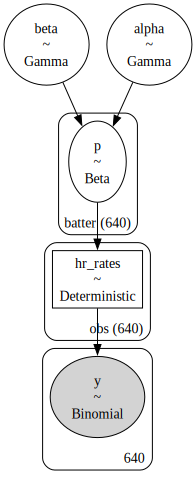

In [40]:
with beta_partial_pooling_model:

    p = pm.Beta("p", alpha, beta, dims = "batter")

    hr_rates = pm.Deterministic("hr_rates", p[batter_idx], dims = "obs")

    y = pm.Binomial("y", n = pa, p = hr_rates, observed = hr)

pm.model_to_graphviz(beta_partial_pooling_model)

Sampling: [alpha, beta, p, y]


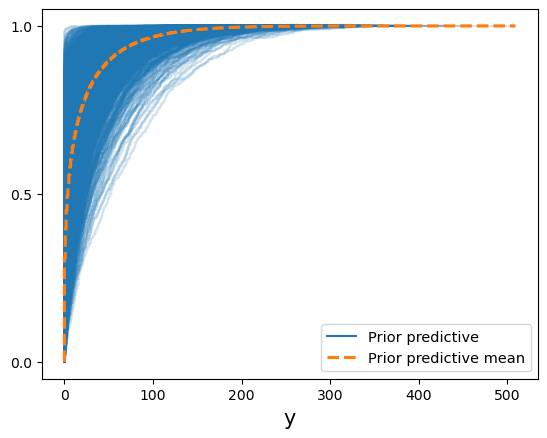

In [41]:
with beta_partial_pooling_model:
    beta_partial_pooling_trace = pm.sample_prior_predictive(1000)

az.plot_ppc(beta_partial_pooling_trace, group="prior", kind="cumulative");

In [42]:
with beta_partial_pooling_model:
    beta_partial_pooling_trace.extend(pm.sample(chains=4, cores=4, random_seed=RANDOM_SEED))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [43]:
with beta_partial_pooling_model:
    pm.sample_posterior_predictive(beta_partial_pooling_trace, extend_inferencedata=True)

Sampling: [y]


array([<Axes: xlabel='y'>], dtype=object)

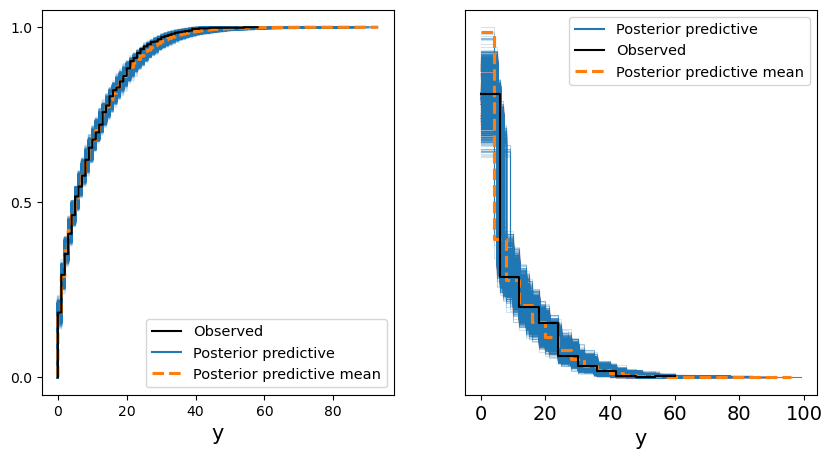

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
az.plot_ppc(beta_partial_pooling_trace, group = "posterior", kind = "cumulative", ax=axes[0])
az.plot_ppc(beta_partial_pooling_trace, group = "posterior", ax = axes[1])

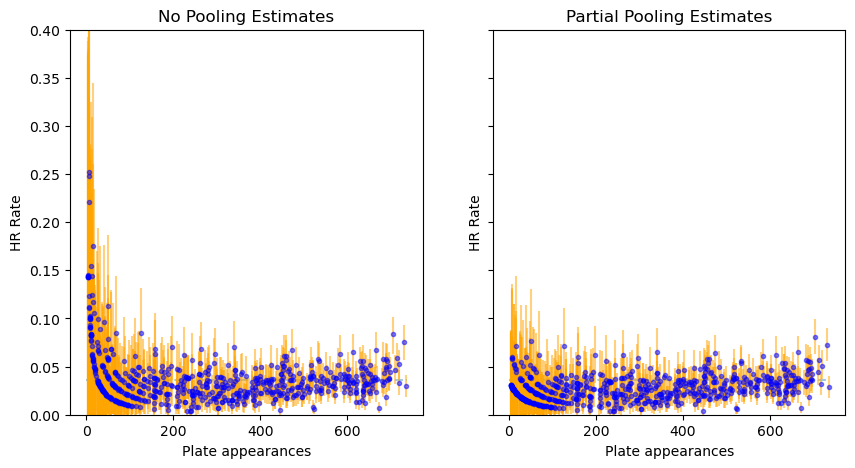

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)

N_pa = fitting_subset["PA"].to_numpy().squeeze()
for ax, trace, level, idx in zip(
    axes,
    (uninformed_prior_trace, beta_partial_pooling_trace),
    ("no pooling", "partial pooling"),
    (slice(0, len(N_pa)), batter_idx)
):
    alpha = beta_partial_pooling_trace.posterior.alpha.mean()
    beta = beta_partial_pooling_trace.posterior.beta.mean()
    ax.hlines(
        alpha / (alpha + beta),
        0.,
        N_pa.max() + 1,
        alpha = 0.4,
        ls="--",
        label = "Est. population mean",
    )

    hdi = az.hdi(trace).p[idx]
    ax.vlines(N_pa, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color = "orange", alpha=0.5)

    ax.plot(
        N_pa,
        trace.posterior.mean(dim=("chain","draw")).p[idx],
        "b.", alpha=0.5
    )

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Plate appearances",
        ylabel="HR Rate",
        ylim=(0,0.4)
    )
        

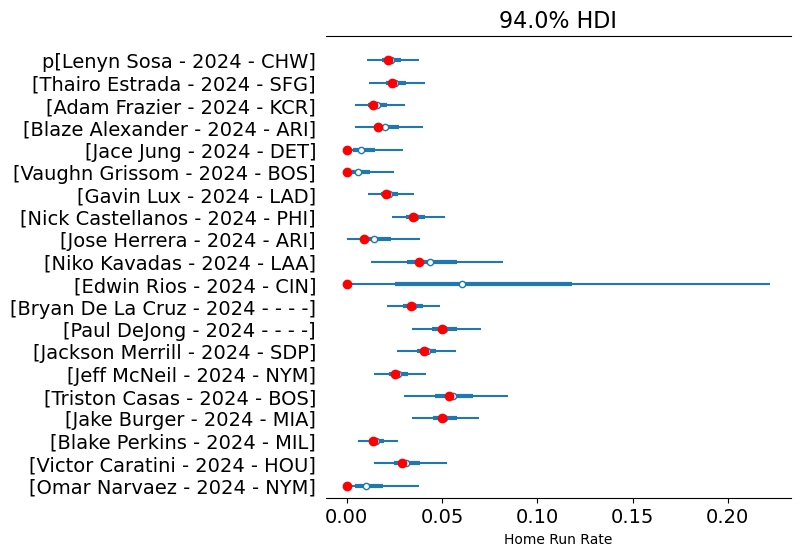

In [46]:
(ax,) = az.plot_forest(uninformed_prior_trace, coords={"batter": list(SAMPLE_BATTERS)}, combined=True)
ax.plot(obs_rates[::-1], ax.get_yticks(), "ro")
ax.set_xlabel("Home Run Rate");
xlim = ax.get_xlim();

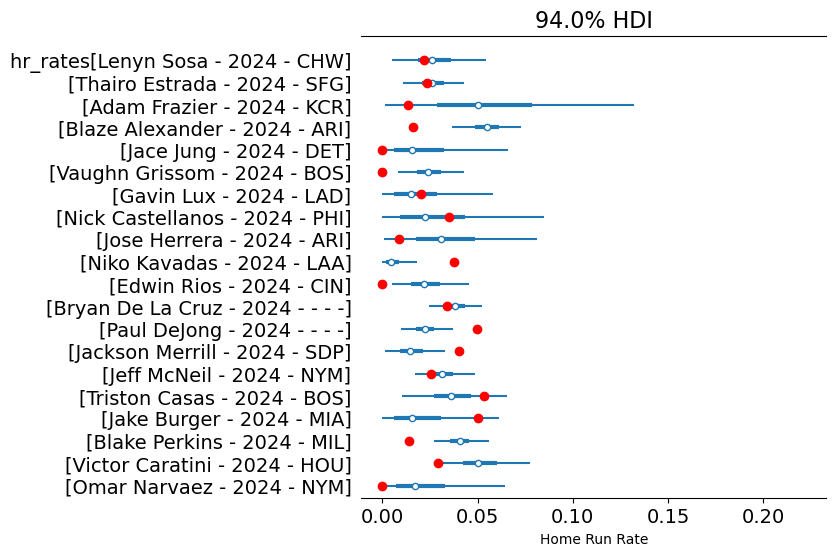

In [47]:
(ax,) = az.plot_forest(beta_partial_pooling_trace.posterior["hr_rates"], coords={"obs": SAMPLE_BATTERS}, combined=True)
ax.plot(obs_rates[::-1], ax.get_yticks(),"ro")
ax.set_xlabel("Home Run Rate")
ax.set_xlim(xlim);

## Group Covariate Model ##

$$
logit(p_i) \sim N(\theta_i,\sigma^2)
$$

$$
\theta_i = \mu_j[i] + \epsilon_i
$$

$$
\mu \sim N(m_\mu, s_\mu), \epsilon_i ~ N(0, \sigma)
$$

Where j corresponds the the group, position, that batter i belongs to

In [48]:
fitting_subset["pos"] = fitting_subset["pos"].replace({"1B": "1B_DH", "DH": "1B_DH"})

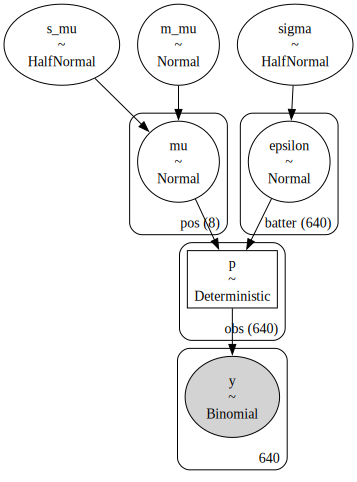

In [49]:
position_idx, positions = factorize(fitting_subset, "pos")

coords["pos"] = positions

with pm.Model(coords=coords) as position_means_model:
    m_mu = pm.Normal("m_mu", mu=-2, sigma=1)
    s_mu = pm.HalfNormal("s_mu", 1)
    mu = pm.Normal("mu", mu=m_mu, sigma=s_mu, dims="pos")

    sigma = pm.HalfNormal("sigma", 1)
    epsilon = pm.Normal("epsilon", mu=0, sigma=sigma, dims = "batter")

    p = pm.Deterministic("p", pm.math.invlogit(mu[position_idx] + epsilon[batter_idx]), dims="obs")

    y = pm.Binomial("y", n=pa, p=p, observed=hr)

pm.model_to_graphviz(position_means_model)
    

In [50]:
with position_means_model:
    position_means_trace = pm.sample(1000, tune = 2000, chains = 4, cores=4, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_mu, s_mu, mu, sigma, epsilon]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 15 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


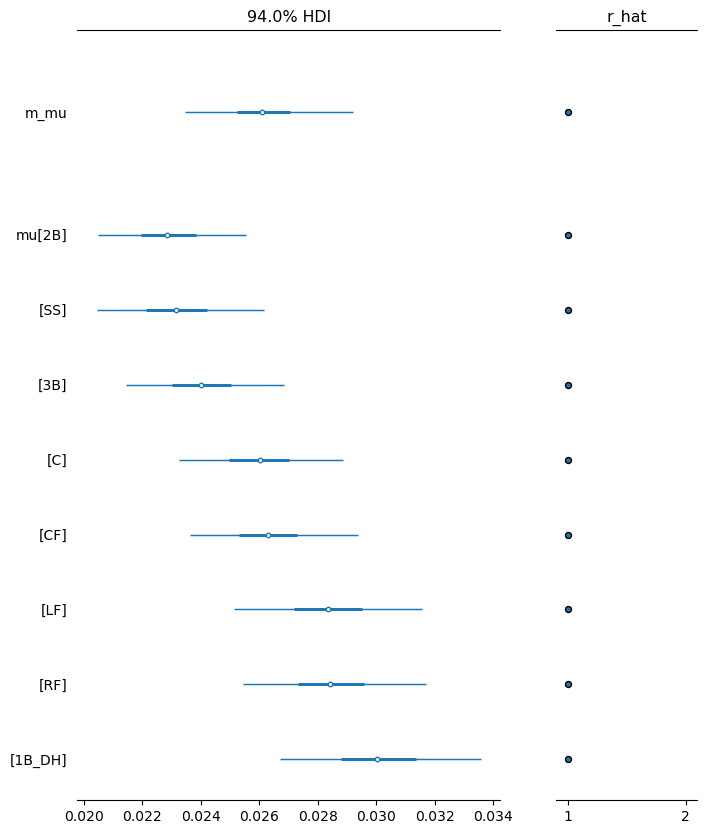

In [51]:
position_means = position_means_trace.posterior["mu"].mean(("chain", "draw"))
sorted_positions = position_means_trace.posterior["pos"].sortby(position_means)

az.plot_forest(
    position_means_trace,
    var_names=["m_mu","mu"],
    r_hat=True,
    combined=True,
    figsize=(8,10),
    textsize=10,
    coords={"pos": sorted_positions},
    transform=lambda x: 1 / (1 + np.exp(-x)),
);

In [53]:
hr = hr.astype(np.float64)
#hr[0] = np.nan

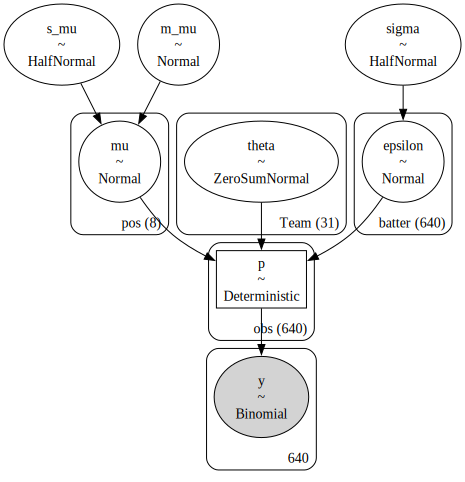

In [54]:
team_idx, teams = factorize(fitting_subset, "Team")

coords["Team"] = teams
#fitting_subset["Team"] = fitting_subset["Team"].replace('- - -', np.nan)


with pm.Model(coords=coords) as team_model:
    m_mu = pm.Normal("m_mu", mu = -2, sigma=1)
    s_mu = pm.HalfNormal("s_mu", 1)
    mu = pm.Normal("mu", mu = m_mu, sigma=s_mu, dims="pos")

    theta = pm.ZeroSumNormal("theta", sigma=1, dims="Team")

    sigma = pm.HalfNormal("sigma",1)
    epsilon = pm.Normal("epsilon", mu=0, sigma=sigma, dims="batter")

    p = pm.Deterministic("p", pm.math.invlogit(mu[position_idx] + theta[team_idx] + epsilon[batter_idx]), dims = "obs")

    y = pm.Binomial("y", n = pa, p = p, observed = hr)

pm.model_to_graphviz(team_model)

In [55]:
with team_model:
    team_trace = pm.sample(1000, tune=2000, chains=4, cores=4, target_accept=0.9, random_seed = RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_mu, s_mu, mu, theta, sigma, epsilon]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.


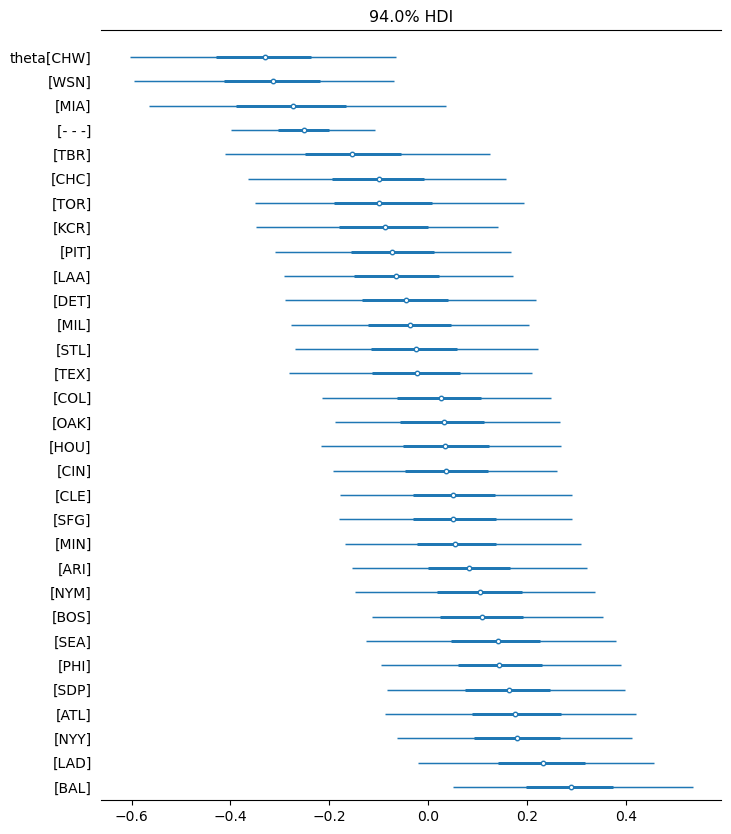

In [56]:
team_means = team_trace.posterior['theta'].mean(("chain", "draw"))
sorted_teams = team_trace.posterior["Team"].sortby(team_means)

az.plot_forest(
    team_trace,
    var_names=["theta"],
    r_hat=False,
    combined=True,
    figsize=(8,10),
    textsize=10,
    coords={"Team": sorted_teams},
);

In [57]:
with uninformative_prior_model:
    pm.compute_log_likelihood(uninformed_prior_trace)

az.loo(uninformed_prior_trace, uninformative_prior_model)

Computed from 4000 posterior samples and 640 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1856.21    15.53
p_loo      617.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       74   11.6%
   (0.70, 1]   (bad)       401   62.7%
   (1, Inf)   (very bad)  165   25.8%

In [58]:
with informative_prior_model:
    pm.compute_log_likelihood(informed_prior_trace)

In [59]:
az.loo(informed_prior_trace, informative_prior_model)

Computed from 4000 posterior samples and 640 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -3278.14    81.17
p_loo      826.50        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      485   75.8%
   (0.70, 1]   (bad)       126   19.7%
   (1, Inf)   (very bad)   29    4.5%

In [60]:
with beta_partial_pooling_model:
    pm.compute_log_likelihood(beta_partial_pooling_trace)

with team_model:
    pm.compute_log_likelihood(team_trace)

In [61]:
az.loo(team_trace, team_model)

Computed from 4000 posterior samples and 640 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1527.87    27.38
p_loo      266.97        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      455   71.1%
   (0.70, 1]   (bad)       172   26.9%
   (1, Inf)   (very bad)   13    2.0%

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

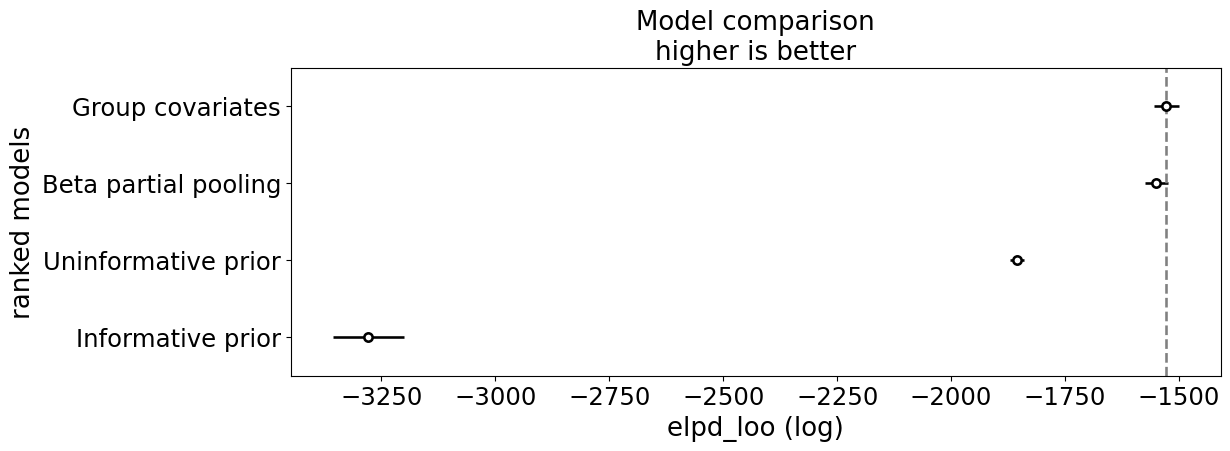

In [62]:
model_compare = az.compare(
    {
        "Uninformative prior": uninformed_prior_trace,
        "Informative prior": informed_prior_trace,
        "Beta partial pooling": beta_partial_pooling_trace,
        "Group covariates": team_trace
    }, method="BB-pseudo-BMA"
)
az.plot_compare(model_compare, figsize=(12,4), insample_dev=False)

In [63]:
model_compare.round(2)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Group covariates,0,-1527.87,266.97,0.00,0.95,26.66,0.00,True,log
Beta partial pooling,1,-1549.84,360.22,21.97,0.05,24.78,13.49,True,log
Uninformative prior,2,-1856.21,617.55,328.34,0.00,15.61,17.51,True,log
Informative prior,3,-3278.14,826.50,1750.27,0.00,77.69,72.71,True,log


## Individual Covariates

$$
logit(p_i) \sim N(\theta_i + X_i \beta,\sigma^2)
$$

$$
\theta_i = \mu_j[i] +\epsilon_i
$$

$x_i$ is the average exit velocity for batter $i$

In [64]:
la_ev = fitting_subset[["LA","EV"]]

X = (
    (fitting_subset[["LA", "EV"]] - fitting_subset[["LA", "EV"]].mean()) 
    / fitting_subset[["LA", "EV"]].std()
).to_numpy()

In [63]:
X

array([[2.27182779e-01, 8.91764370e-01],
       [2.27182779e-01, 1.27564141e+00],
       [4.97214311e-01, 2.42727255e+00],
       ...,
       [2.27182779e-01, 5.07887325e-01],
       [2.15650182e-03, 1.56000034e-01],
       [3.17193289e-01, 2.80410185e-02]])

In [65]:
la = fitting_subset[["LA"]]
ev = fitting_subset[["EV"]]

In [61]:
hr = hr.astype(np.float64)
#hr[0] = np.nan

In [66]:
ev_centered = (fitting_subset["EV"] - fitting_subset["EV"].mean()) / fitting_subset["EV"].std()
la_centered = (fitting_subset["LA"] - fitting_subset["LA"].mean()) / fitting_subset["LA"].std()

In [69]:
coords['la'] = la
coords['ev'] = ev

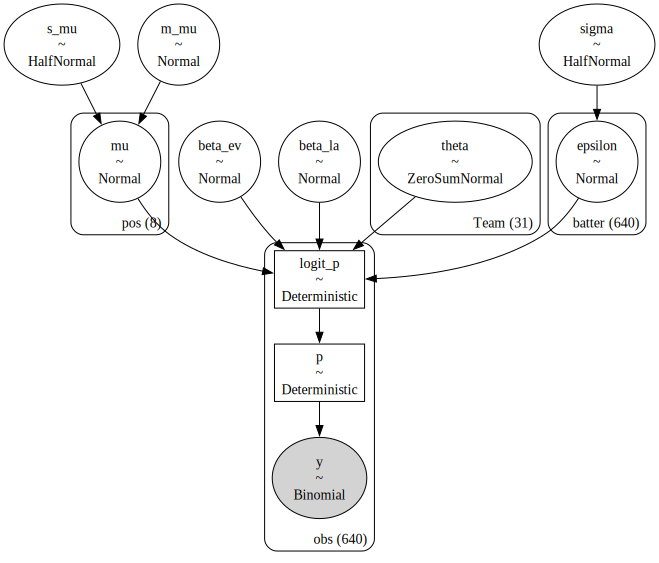

In [70]:
with pm.Model(coords=coords) as individual_covariate_model:

    m_mu = pm.Normal("m_mu", mu=-2, sigma=1)
    s_mu = pm.HalfNormal("s_mu", 1)
    mu = pm.Normal("mu", mu = m_mu, sigma = s_mu, dims = "pos")

    theta = pm.ZeroSumNormal("theta", sigma = 1, dims="Team")

    sigma = pm.HalfNormal("sigma", 1)
    epsilon = pm.Normal("epsilon", mu = 0, sigma=sigma, dims="batter")

    beta_la = pm.Normal("beta_la", mu=0, sigma=1)
    beta_ev = pm.Normal("beta_ev", mu=0, sigma=1) 

    la_contrib = beta_la * ev_centered
    ev_contrib = beta_ev * la_centered

    logit_p = pm.Deterministic("logit_p",
        mu[position_idx] + theta[team_idx] + epsilon[batter_idx] + la_contrib + ev_contrib, dims = "obs")

    p = pm.Deterministic("p", pm.math.invlogit(logit_p), dims = "obs")

    y = pm.Binomial("y", n = pa, p = p, observed = hr, dims = 'obs')

pm.model_to_graphviz(individual_covariate_model)

In [71]:
with individual_covariate_model:
    individual_covariate_trace = pm.sample(1000, tune=2000, chains = 2, random_seed= RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [m_mu, s_mu, mu, theta, sigma, epsilon, beta_la, beta_ev]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 15 seconds.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


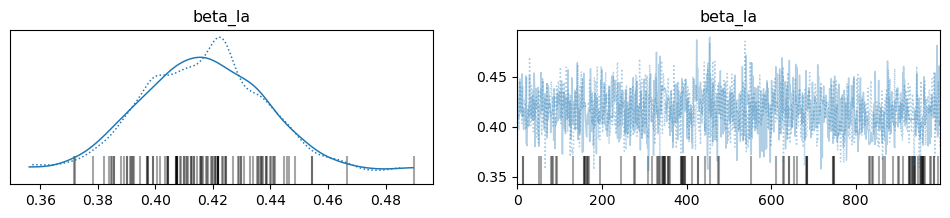

In [72]:
az.plot_trace(individual_covariate_trace, var_names=['beta_la']);

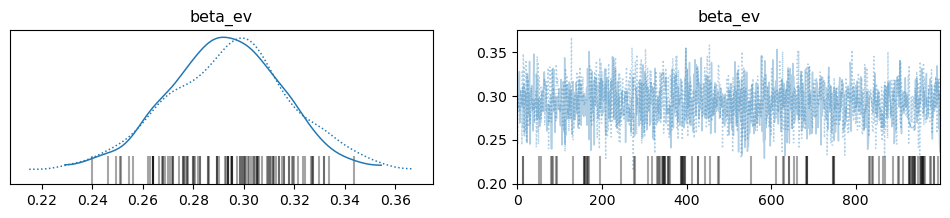

In [73]:
az.plot_trace(individual_covariate_trace, var_names=['beta_ev']);

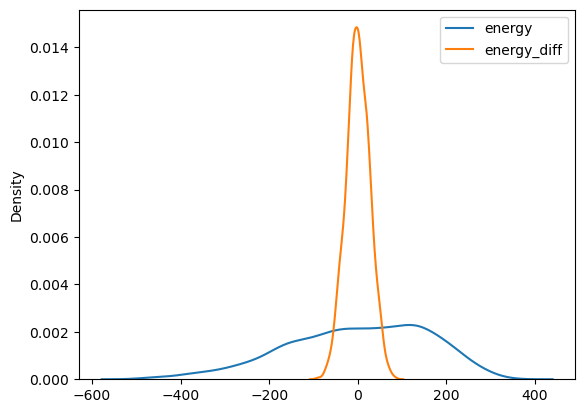

In [74]:
energy = individual_covariate_trace.sample_stats['energy'].values.ravel()
energy_diff = np.diff(energy)
sns.kdeplot(energy - energy.mean(), label='energy')
sns.kdeplot(energy_diff, label='energy_diff')
plt.legend()

<Axes: >

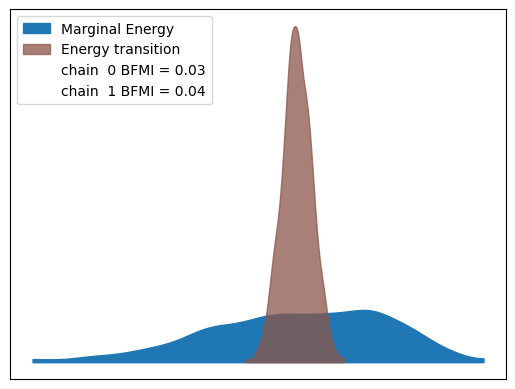

In [75]:
az.plot_energy(individual_covariate_trace)

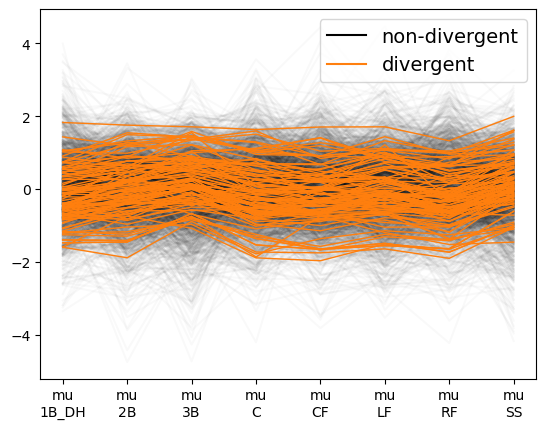

In [76]:
az.plot_parallel(individual_covariate_trace, var_names=["mu"], norm_method="normal");

<Axes: title={'center': 'scatter plot between s_mu and mu[0]'}, xlabel='mu[0]', ylabel='s_mu'>

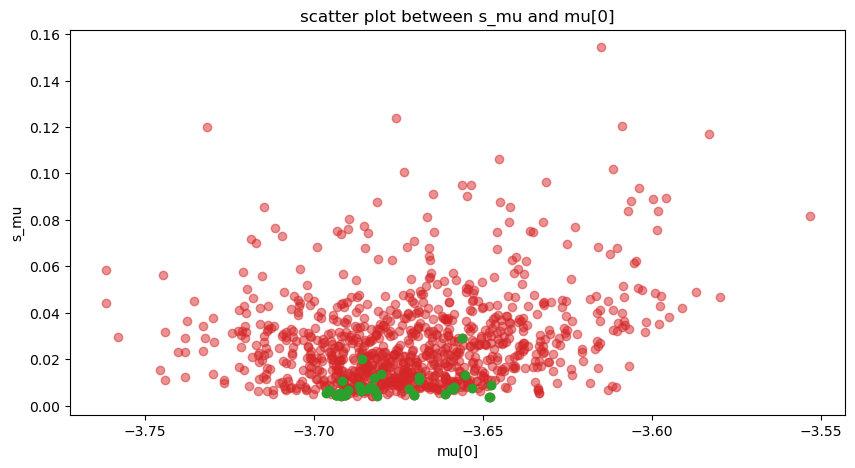

In [77]:
def pairplot_divergence(trace, ax=None, divergence=True, color="C3", divergence_color="C2", chain=1):
    mu = individual_covariate_trace.posterior.sel(chain=chain).mu[:, 0]
    s_mu = individual_covariate_trace.posterior.sel(chain=1).s_mu
    if not ax:
        _, ax = plt.subplots(1,1, figsize=(10,5))
    ax.plot(mu, s_mu, "o", color=color, alpha=0.5)
    if divergence:
        divergent = trace.sample_stats["diverging"][chain]
        ax.plot(mu[divergent], s_mu[divergent], "o", color=divergence_color)
    ax.set_xlabel("mu[0]")
    ax.set_ylabel("s_mu")
    ax.set_title("scatter plot between s_mu and mu[0]")
    return ax

pairplot_divergence(individual_covariate_trace)
    

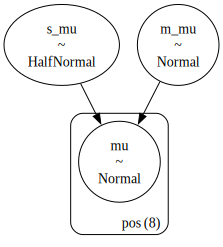

In [78]:
with pm.Model(coords=coords) as centered_re:
    m_mu = pm.Normal("m_mu", mu=-2, sigma=1)
    s_mu = pm.HalfNormal("s_mu", 1)
    mu = pm.Normal("mu", mu=m_mu, sigma=s_mu,dims="pos")

pm.model_to_graphviz(centered_re)

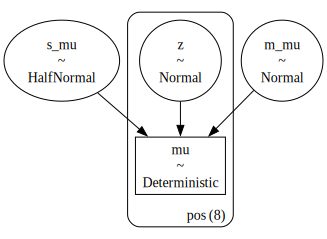

In [79]:
with pm.Model(coords=coords) as noncentered_re:
    m_mu = pm.Normal("m_mu", mu = -2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    z = pm.Normal('z', mu = 0, sigma = 1, dims="pos")
    mu = pm.Deterministic("mu", m_mu + s_mu * z, dims = "pos")

pm.model_to_graphviz(noncentered_re)

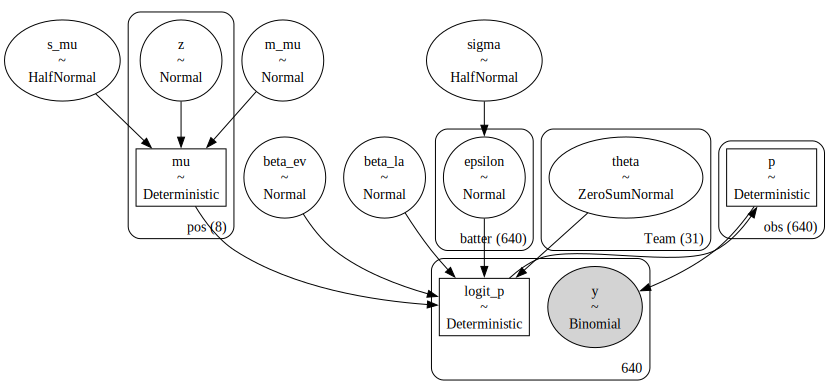

In [82]:
with pm.Model(coords=coords) as noncentered_individual_covariate_model:

    #Non-centered random effect
    m_mu = pm.Normal('m_mu', mu=-2, sigma=1)
    s_mu = pm.HalfNormal('s_mu', 1)
    z = pm.Normal('z', mu=0, sigma=1, dims='pos')
    mu = pm.Deterministic('mu', m_mu + s_mu * z, dims='pos')

    sigma = pm.HalfNormal('sigma', 1)
    epsilon = pm.Normal('epsilon', mu=0, sigma=sigma, dims='batter')

    theta = pm.ZeroSumNormal('theta', sigma=1, dims='Team')

    #beta = pm.Normal('beta', mu=0, sigma=1, dims='metric')

    beta_la = pm.Normal("beta_la", mu=0, sigma=1)
    beta_ev = pm.Normal("beta_ev", mu=0, sigma=1) 

    la_contrib = beta_la * ev_centered
    ev_contrib = beta_ev * la_centered
    
    logit_p = pm.Deterministic('logit_p',
        mu[position_idx] + theta[team_idx] + epsilon[batter_idx] + la_contrib + ev_contrib,
    )

    p = pm.Deterministic('p', pm.math.invlogit(logit_p), dims='obs')

    y = pm.Binomial('y', n=pa, p=p, observed=hr)

pm.model_to_graphviz(noncentered_individual_covariate_model)

In [83]:
with noncentered_individual_covariate_model:
    noncentered_individual_covariate_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_mu, s_mu, z, sigma, epsilon, theta, beta_la, beta_ev]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [86]:
print(az.summary(team_trace))

                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  \
m_mu                            -3.607  0.063  -3.722   -3.487      0.001   
mu[1B_DH]                       -3.476  0.065  -3.596   -3.355      0.001   
mu[2B]                          -3.744  0.062  -3.872   -3.636      0.001   
mu[3B]                          -3.690  0.064  -3.806   -3.565      0.001   
mu[C]                           -3.624  0.060  -3.739   -3.514      0.001   
...                                ...    ...     ...      ...        ...   
p[Zach Neto - 2024 - LAA]        0.037  0.007   0.025    0.049      0.000   
p[Zach Remillard - 2024 - CHW]   0.028  0.006   0.018    0.039      0.000   
p[Zachary Dezenzo - 2024 - HOU]  0.046  0.007   0.033    0.060      0.000   
p[Zack Gelof - 2024 - OAK]       0.024  0.005   0.015    0.034      0.000   
p[Zack Short - 2024 - - - -]     0.035  0.006   0.023    0.046      0.000   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
m_mu 

In [87]:
print(az.summary(individual_covariate_trace))

                                  mean     sd  hdi_3%  hdi_97%  mcse_mean  \
m_mu                            -3.677  0.022  -3.718   -3.635      0.002   
mu[1B_DH]                       -3.669  0.029  -3.723   -3.615      0.002   
mu[2B]                          -3.680  0.028  -3.729   -3.626      0.002   
mu[3B]                          -3.689  0.030  -3.743   -3.632      0.002   
mu[C]                           -3.673  0.026  -3.723   -3.624      0.002   
...                                ...    ...     ...      ...        ...   
p[Zach Neto - 2024 - LAA]        0.039  0.005   0.031    0.048      0.000   
p[Zach Remillard - 2024 - CHW]   0.033  0.004   0.025    0.041      0.000   
p[Zachary Dezenzo - 2024 - HOU]  0.040  0.005   0.031    0.049      0.000   
p[Zack Gelof - 2024 - OAK]       0.024  0.003   0.020    0.030      0.000   
p[Zack Short - 2024 - - - -]     0.031  0.004   0.024    0.038      0.000   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
m_mu 

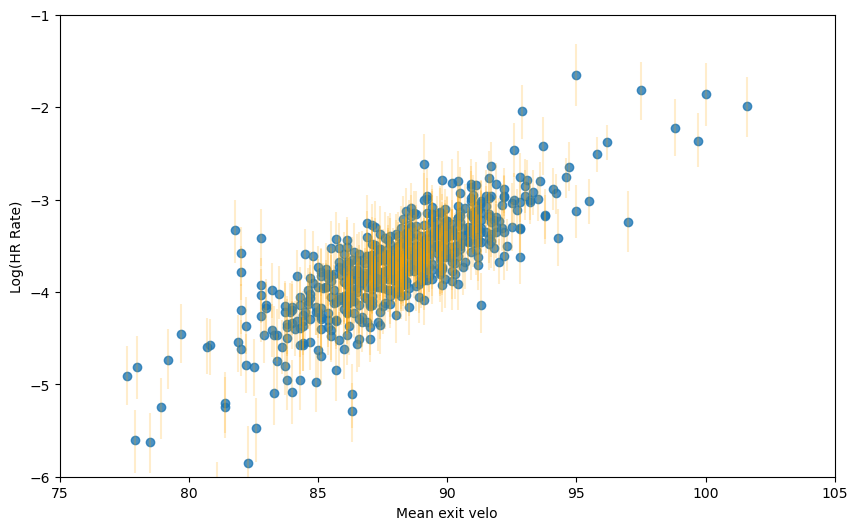

In [92]:
ev = fitting_subset["EV"].to_numpy().squeeze()
post = noncentered_individual_covariate_trace.posterior.assign_coords(ev=ev)
avg_p = post["logit_p"].mean(dim=("chain","draw")).values[np.argsort(ev)]
avg_p_hdi = az.hdi(post, var_names="logit_p")["logit_p"]

_, ax = plt.subplots(figsize=(10,6))
ax.vlines(
    ev,
    avg_p_hdi.sel(hdi="lower"),
    avg_p_hdi.sel(hdi="higher"),
    alpha=0.2,
    color="orange",
)
ax.scatter(ev[np.argsort(ev)], avg_p, alpha=0.8)

plt.xlim(75,105)
plt.ylim(-6,-1)
plt.xlabel("Mean exit velo")
plt.ylabel("Log(HR Rate)");

In [94]:
with noncentered_individual_covariate_model:
    pm.compute_log_likelihood(noncentered_individual_covariate_trace)


In [95]:
with individual_covariate_model:
    pm.compute_log_likelihood(individual_covariate_trace)

In [96]:
az.loo(individual_covariate_trace, individual_covariate_model)

Computed from 2000 posterior samples and 640 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1381.24    26.76
p_loo       86.80        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      633   98.9%
   (0.70, 1]   (bad)         7    1.1%
   (1, Inf)   (very bad)    0    0.0%

In [102]:
az.loo(noncentered_individual_covariate_trace, noncentered_individual_covariate_model)

Computed from 4000 posterior samples and 640 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1381.91    26.76
p_loo       88.65        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      636   99.4%
   (0.70, 1]   (bad)         4    0.6%
   (1, Inf)   (very bad)    0    0.0%

In [97]:
noncentered_individual_covariate_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

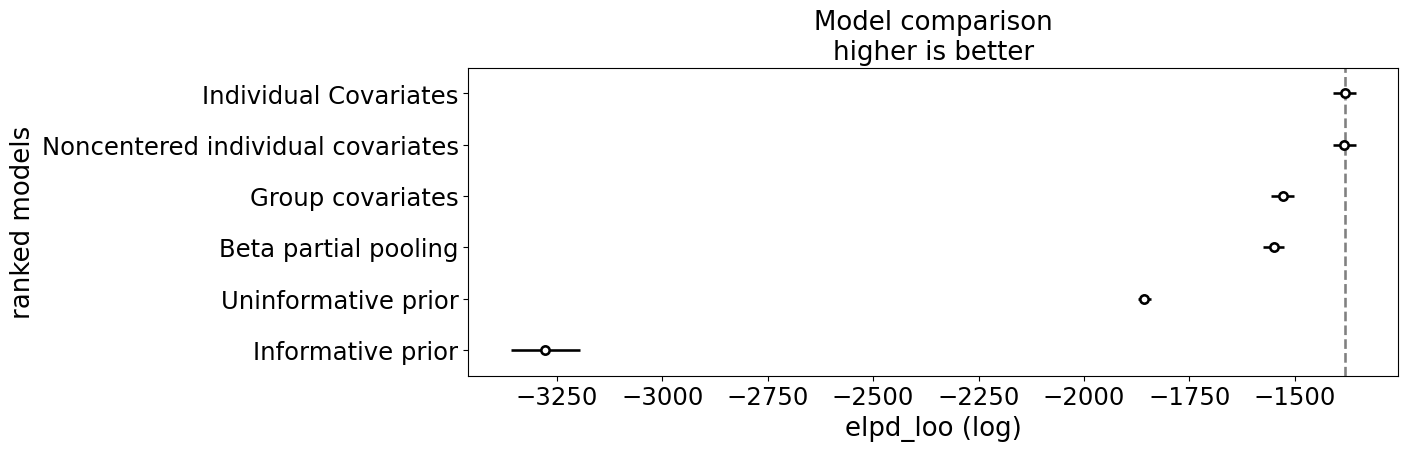

In [109]:
full_model_compare = az.compare(
    {
        "Uninformative prior": uninformed_prior_trace,
        "Informative prior": informed_prior_trace,
        "Beta partial pooling": beta_partial_pooling_trace,
        "Group covariates": team_trace,
        "Individual Covariates": individual_covariate_trace,
        "Noncentered individual covariates": noncentered_individual_covariate_trace
    }, method="BB-pseudo-BMA"
)
az.plot_compare(model_compare, figsize=(12,4), insample_dev=False)

In [110]:
full_model_compare.round(2)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Individual Covariates,0,-1381.24,86.80,0.00,0.65,26.45,0.00,True,log
Noncentered individual covariates,1,-1381.91,88.65,0.67,0.35,26.46,0.64,True,log
Group covariates,2,-1527.87,266.97,146.63,0.00,26.49,14.38,True,log
Beta partial pooling,3,-1549.84,360.22,168.60,0.00,23.99,16.05,True,log
Uninformative prior,4,-1856.21,617.55,474.97,0.00,14.49,18.14,True,log
Informative prior,5,-3278.14,826.50,1896.90,0.00,83.13,74.78,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

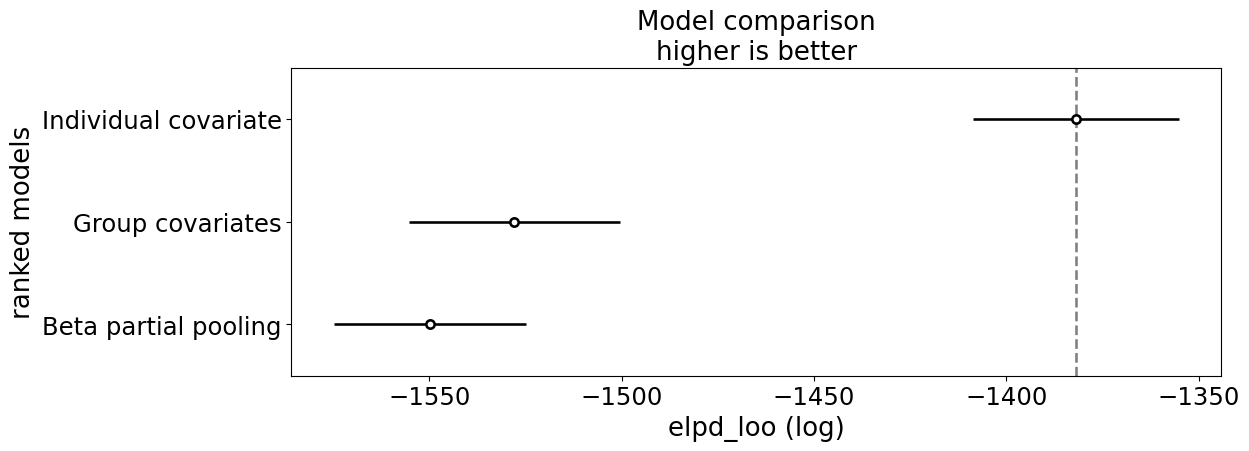

In [107]:
model_compare = az.compare(
    {
        "Beta partial pooling": beta_partial_pooling_trace,
        "Group covariates": team_trace,
        "Individual covariate": noncentered_individual_covariate_trace
    }
)
az.plot_compare(model_compare, figsize=(12,4), insample_dev=False)